# Определение оттока клиентов оператора связи

### Цель исследования

В рамках исследования требуется разработать модель бинарной классификации для оператора связи «Ниединогоразрыва.ком», которая прогнозирует отток клиентов на основе персональных данных клиентов, включая информацию информацию об их тарифах и договорах. Основное пожелание заказчика - снизить убытки, связанные с неэффективными акциями по удержанию клиентов.

Основная метрика качества **AUC-ROC**: больше 0,85.

Дополнительная метрика качества **accuracy**.

**Описание услуг**  

Оператор предоставляет два основных типа услуг: 

* Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
* Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line, «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).

Также доступны такие услуги:

* Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
* Выделенная линия технической поддержки (TechSupport);
* Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
* Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

**Описание данных** 

Данные состоят из файлов, полученных из разных источников:
* contract_new.csv — информация о договоре;
* personal_new.csv — персональные данные клиента;
* internet_new.csv — информация об интернет-услугах;
* phone_new.csv — информация об услугах телефонии.

Во всех файлах столбец ***customerID*** содержит код клиента.  
Информация о договорах актуальна на ***1 февраля 2020***.

### План работ

Для выполнения поставленной задачи потребуется выполнить следущие этапы:

1. Импорт библиотек и загрузка данных
2. Объединение данных и выделение целевого признака
3. Предобработка данных
4. Исследовательский анализ данных
5. Формирование выборок, масштабирование и кодирование данных
6. Обучение моделей и подбор гиперпараметров
7. Выбор лучшей модели и проверка ее метрики на тестовой выборке
8. Анализ важности признаков и метрик качества (построение ROC-кривой и матрицы ошибок)
9. Составление отчета по результатам исследования

### Импорт библиотек и загрузка данных

In [1]:
%pip install missingno -q

Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install phik -q

In [3]:
!pip install shap -q

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce
import re

from sklearn.utils import shuffle
from sklearn.pipeline import Pipeline
import sklearn.metrics as metrics
from sklearn.metrics import (
    roc_curve,
    roc_auc_score,
    confusion_matrix,
    accuracy_score
)
from sklearn.compose import make_column_transformer
from sklearn.model_selection import (
    GridSearchCV, 
    RandomizedSearchCV,
    train_test_split
)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler
)

from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
import itertools
from itertools import product

import missingno as msno

import phik
from phik.report import plot_correlation_matrix

import shap 

import sys
import warnings
if not sys.warnoptions:
       warnings.simplefilter('ignore')

print('Setup Complete')

Setup Complete


In [5]:
try:
    df_contract = pd.read_csv('contract_new.csv')
    df_internet = pd.read_csv('internet_new.csv')
    df_personal = pd.read_csv('personal_new.csv')
    df_phone = pd.read_csv('phone_new.csv')
    
except:
    df_contract = pd.read_csv('/datasets/contract_new.csv')
    df_internet = pd.read_csv('/datasets/internet_new.csv')
    df_personal = pd.read_csv('/datasets/personal_new.csv')
    df_phone = pd.read_csv('/datasets/phone_new.csv')

In [6]:
df_contract.sample(3)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
4090,1453-RZFON,2020-01-01,No,Month-to-month,No,Mailed check,49.90,52.4
6489,9318-NKNFC,2019-11-01,No,Month-to-month,Yes,Mailed check,18.85,57.68
5494,8837-VVWLQ,2019-02-01,No,Month-to-month,No,Electronic check,84.95,1019.4


**Описание данных**  
* ***customerID*** - идентификатор пользователя (представлен в каждой таблице - по нему будем производить объединение)
* ***BeginDate*** - дата начала пользования услугами
* ***EndDate*** - дата окончания пользования услугами. Если указано "No", значит клиент продолжает пользоваться услугами оператора, в ином случае - клиент ушел. Это значение и является целевой переменной. Для нее потребуется создать дополнительное поле, где 0 - клиент остался, 1 - клиент ушел
* ***Type*** - тип договора (ежемесячный, на 1 год, на 2 года)
* ***PaperlessBilling*** - выставление счета по электронной почте (бинарный признак Yes/No)
* ***PaymentMethod*** - способ оплаты (электронный чек, чек по почте формируется в ручную или автоматически)
* ***MonthlyCharges*** - ежемесячные траты на услуги
* ***TotalCharges*** - всего потрачено на услуги

In [7]:
df_internet.sample(3)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
4227,0292-WEGCH,DSL,No,Yes,Yes,Yes,Yes,Yes
2292,1428-GTBJJ,Fiber optic,No,Yes,No,No,No,No
651,3551-GAEGL,DSL,Yes,No,No,No,No,No


**Описание данных**
* ***InternetService*** - наличие услуги Интернет (Fiber optic, DSL или отсутствует)
* ***OnlineSecurity*** - межсетевой экран (бинарный признак Yes/No)
* ***OnlineBackup*** - облачное хранилище (бинарный признак Yes/No)
* ***DeviceProtection*** - антивирус (бинарный признак Yes/No)
* ***TechSupport*** - выделенная линия техподдержки (бинарный признак Yes/No)
* ***StreamingTV*** - онлайн-ТВ (бинарный признак Yes/No)
* ***StreamingMovies*** - онлайн-кинотеатр (бинарный признак Yes/No)

In [8]:
df_personal.sample(3)

,customerID,gender,SeniorCitizen,Partner,Dependents
5338,2580-ASVVY,Female,0,Yes,No
3836,6872-HXFNF,Female,0,Yes,No
6524,2754-VDLTR,Male,0,No,Yes


**Описание данных**  
* ***gender*** - пол клиента (бинарный признак Male/Female)
* ***SeniorCitizen*** - пенсионный статус (бинарный признак 0/1)
* ***Partner*** - наличие супруги/супруга (бинарный признак Yes/No)
* ***Dependents*** - наличие иждивенцев (бинарный признак Yes/No)

In [9]:
df_phone.sample(3)

,customerID,MultipleLines
6256,2595-KIWPV,No
5822,3266-FTKHB,No
593,5183-SNMJQ,No


**Описание данных**
* ***MultipleLines*** - возможность подключения телефонного аппарата к нескольким линиям одновременно (бинарный признак Yes/No)

**Выводы**  
* Данные загружены корректно.
* Объединение таблиц выполним по полю "customerID".
* Целевая переменная будет выделена на следующем этапе из значений поля "EndDate".

### Объединение данных и выделение целевого признака

In [10]:
# объединим таблицы по полю customerID

data = [df_contract, df_personal, df_internet, df_phone]

df = reduce(lambda left, right: pd.merge(left, right, on='customerID', how='outer'), data)

In [11]:
# функция для разметки данных по дате окончания действия договора

def label_exited(end_date):
    if end_date == 'No':
        return 0
    else:
        return 1

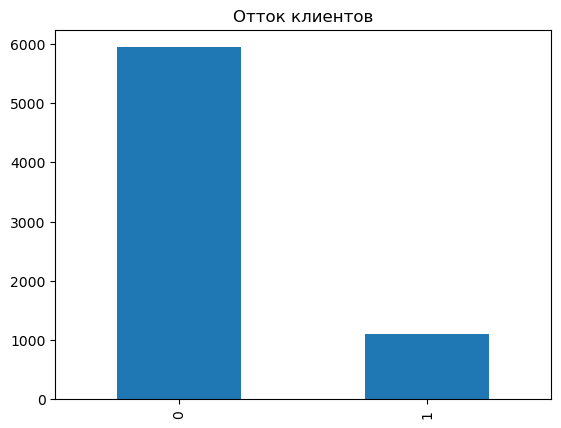

In [12]:
# формируем столбец с целевой переменной

df['exited'] = df['EndDate'].apply(label_exited)
df['exited'].value_counts().plot(kind='bar')
plt.title('Отток клиентов');

In [13]:
df.sample(5)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,...,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,exited
798,3807-XHCJH,2020-01-01,No,Month-to-month,No,Electronic check,20.00,20.8,Female,0,...,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,0
2502,9067-YGSCA,2014-04-01,No,One year,No,Credit card (automatic),26.05,1823.5,Female,0,...,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,0
6114,4226-KKDON,2019-06-01,No,Month-to-month,Yes,Electronic check,66.65,559.86,Male,0,...,No,DSL,No,Yes,No,Yes,Yes,No,No,0
4995,7912-SYRQT,2019-05-01,No,Month-to-month,Yes,Bank transfer (automatic),75.10,675.9,Female,0,...,No,Fiber optic,No,No,No,No,No,No,Yes,0
6514,6166-YIPFO,2014-02-01,No,Two year,Yes,Electronic check,64.70,4658.4,Male,0,...,No,DSL,Yes,Yes,Yes,Yes,Yes,Yes,NaN,0


**Выводы**
* Данные были корректно объединены.
* Целевой признак успешно сформирован. На лицо дисбаланс классов - это потребуется учесть при формировании выборок и обучении моделей.

### Предобработка данных

In [14]:
# функция для описательной статистики

def descriptive_statistics(df):
    display(df.sample(10))
    df.info()
    print(round(df.isna().sum()/len(df)*100,2))
    print(df.describe(include='all').T)
    print('\nДубликаты:', df.duplicated().sum())

In [15]:
descriptive_statistics(df)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,...,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,exited
83,9919-YLNNG,2016-08-01,No,Month-to-month,Yes,Bank transfer (automatic),103.80,4446.79,Female,0,...,No,Fiber optic,No,Yes,Yes,Yes,Yes,Yes,No,0
3717,0655-YDGFJ,2017-09-01,2019-10-01,Month-to-month,No,Bank transfer (automatic),48.95,1297.17,Male,0,...,No,DSL,No,No,Yes,No,No,No,No,1
4773,8627-EHGIP,2016-05-01,No,One year,Yes,Mailed check,53.95,2427.75,Male,0,...,No,DSL,No,Yes,Yes,No,Yes,Yes,NaN,0
6022,5025-GOOKI,2018-06-01,No,Month-to-month,Yes,Credit card (automatic),18.90,378.0,Female,0,...,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,0
566,6967-QIQRV,2018-11-01,No,One year,No,Electronic check,101.90,1528.5,Male,0,...,Yes,Fiber optic,Yes,No,No,Yes,Yes,Yes,No,0
6002,3727-RJMEO,2019-05-01,No,Month-to-month,Yes,Electronic check,82.85,745.65,Male,0,...,No,Fiber optic,No,No,No,No,Yes,No,Yes,0
1299,4566-QVRRW,2018-11-01,No,Month-to-month,Yes,Electronic check,44.05,660.75,Female,0,...,No,DSL,No,No,No,No,No,No,No,0
4760,3569-VLDHH,2014-08-01,No,One year,Yes,Electronic check,75.10,5105.3,Male,0,...,Yes,DSL,Yes,Yes,Yes,Yes,Yes,No,No,0
5831,9846-GKXAS,2019-03-01,No,Month-to-month,Yes,Bank transfer (automatic),90.80,1048.74,Female,0,...,No,Fiber optic,No,No,No,No,Yes,Yes,No,0
4845,0056-EPFBG,2018-06-01,No,Two year,Yes,Credit card (automatic),39.40,788.0,Male,0,...,Yes,DSL,Yes,No,Yes,Yes,No,No,NaN,0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null   object 


**Выводы**
* Имеются пропущенные значения в параметрах, характеризующих подключение тех или иных услуг.
* Большинство признаков катеогриальные. К числовым относятся только MonthlyCharges и TotalCharges(нужно привести к типу float).
* Для понимания длительности пользования услугами каждого клиента потребуется создать дополнительный столбец. Тогда как поля с датами можно будет удалить (предварительно привести к типу datetime).

In [16]:
# Приведем названия полей к "змеиному" регистру

columns = []
for name in df.columns.values:
    name = re.sub('([A-Z])', r' \1', name).lower().replace(' ', '_')[1:]
    columns.append(name)

In [17]:
df.columns = columns
df = df.rename(columns = {'ustomer_i_d':'customer_id', 'ender':'gender', 'xited':'exited'})
df.columns

Index(['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges', 'gender',
       'senior_citizen', 'partner', 'dependents', 'internet_service',
       'online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_t_v', 'streaming_movies', 'multiple_lines', 'exited'],
      dtype='object')

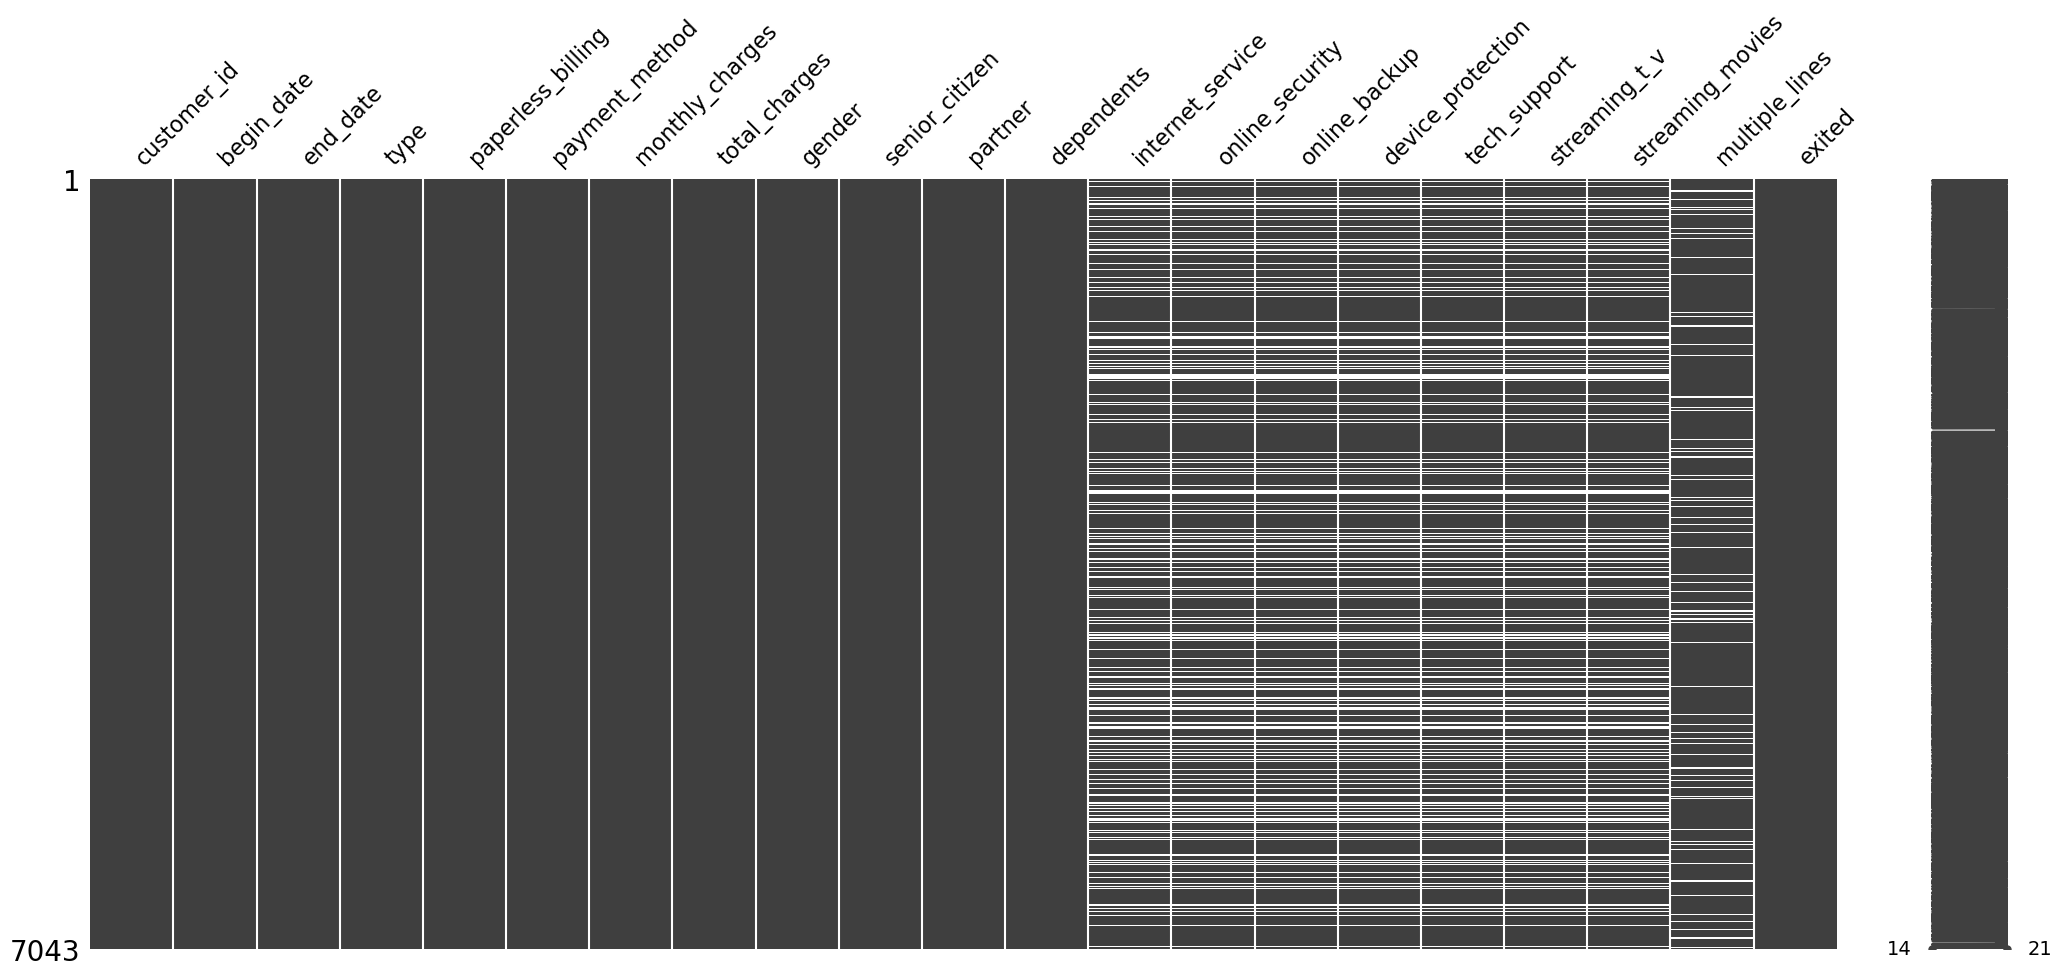

In [18]:
# Посмотрим на пропуски в данных с помощью библиотеки missingno

msno.matrix(df);

**Вывод**  

* Пропуски в полях InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, StreamingTV, StreamingMovies, StreamingMovies совпадают. Наиболее вероятная причина в том, что пользователь вовсе не подключал никакой пакет услуг с Интернетом. Таким образом, можно заполнить все поля значением "No".   

* C отсутствующими данными в поле "MultipleLines" лучше поступить иначе: заполнить их заглушкой (например, 'not available', которая будет указывать на то, что клиент намеренно отказался от данной услуги при подключении.      

**Формирование столбца с длительностью пользования услугами оператора 'days_since_join'**.

In [19]:
# заменим "No" на конечную дату формирования данных для дальнейшего расчета
df.loc[df['end_date'] == 'No', 'end_date'] = '2020-02-01' 

In [20]:
df['begin_date'] = pd.to_datetime(df['begin_date'], format='%Y-%m-%d')
df['end_date'] = pd.to_datetime(df['end_date'], format='%Y-%m-%d')

In [21]:
df['days_since_join'] = (df['end_date'] - df['begin_date']).dt.days

**Заполнение отсутствующих значений**

In [22]:
# Изменения в части заполнения пропусков

df['multiple_lines'] = df['multiple_lines'].fillna('Not available')

In [23]:
df['multiple_lines'].value_counts()

No               3390
Yes              2971
Not available     682
Name: multiple_lines, dtype: int64

In [24]:
columns_miss_values = list(df.columns[df.isnull().any()])
df[columns_miss_values] = df[columns_miss_values].apply(lambda x: x.fillna('No'))

In [25]:
# Проверяем, все ли пропуски заменены
df.isna().sum()

customer_id          0
begin_date           0
end_date             0
type                 0
paperless_billing    0
payment_method       0
monthly_charges      0
total_charges        0
gender               0
senior_citizen       0
partner              0
dependents           0
internet_service     0
online_security      0
online_backup        0
device_protection    0
tech_support         0
streaming_t_v        0
streaming_movies     0
multiple_lines       0
exited               0
days_since_join      0
dtype: int64

**Приводим значения поля 'senior_citizen' к типу object**

In [26]:
df['senior_citizen'] = df['senior_citizen'].astype('object')

**Приводим значения поля 'total_charges' к типу float**

In [27]:
# Просмотр строк, в которых не указано значение 'total_charges'
df[df['total_charges'] == ' ']

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,...,internet_service,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies,multiple_lines,exited,days_since_join
488,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,,Female,0,...,DSL,Yes,No,Yes,Yes,Yes,No,Not available,0,0
753,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,,Male,0,...,No,No,No,No,No,No,No,No,0,0
936,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,,Female,0,...,DSL,Yes,Yes,Yes,No,Yes,Yes,No,0,0
1082,4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,,Male,0,...,No,No,No,No,No,No,No,Yes,0,0
1340,1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,,Female,0,...,DSL,Yes,Yes,Yes,Yes,Yes,No,Not available,0,0
3331,7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,,Male,0,...,No,No,No,No,No,No,No,No,0,0
3826,3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,,Male,0,...,No,No,No,No,No,No,No,Yes,0,0
4380,2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,,Female,0,...,No,No,No,No,No,No,No,No,0,0
5218,2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,,Male,0,...,No,No,No,No,No,No,No,No,0,0
6670,4075-WKNIU,2020-02-01,2020-02-01,Two year,No,Mailed check,73.35,,Female,0,...,DSL,No,Yes,Yes,Yes,Yes,No,Yes,0,0


In [28]:
# Просмотр строк, в которых пользователи пришли в январе 2020
df[df['begin_date'] == '2020-01-01']

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,...,internet_service,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies,multiple_lines,exited,days_since_join
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,...,DSL,No,Yes,No,No,No,No,Not available,0,31
33,7310-EGVHZ,2020-01-01,2020-02-01,Month-to-month,No,Bank transfer (automatic),20.20,22.22,Male,0,...,No,No,No,No,No,No,No,No,0,31
34,3413-BMNZE,2020-01-01,2020-02-01,Month-to-month,No,Bank transfer (automatic),45.25,45.25,Male,1,...,DSL,No,No,No,No,No,No,No,0,31
70,2273-QCKXA,2020-01-01,2020-02-01,Month-to-month,No,Mailed check,49.05,52.48,Male,0,...,DSL,No,No,No,Yes,No,No,No,0,31
91,2424-WVHPL,2020-01-01,2020-02-01,Month-to-month,No,Electronic check,74.70,79.93,Male,1,...,Fiber optic,No,No,No,Yes,No,No,No,0,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6840,1724-IQWNM,2020-01-01,2020-02-01,Month-to-month,Yes,Mailed check,19.30,20.07,Male,0,...,No,No,No,No,No,No,No,No,0,31
6845,6127-IYJOZ,2020-01-01,2020-02-01,Month-to-month,Yes,Mailed check,45.85,45.85,Male,1,...,DSL,No,No,No,No,No,No,No,0,31
6909,9108-EJFJP,2020-01-01,2020-02-01,Month-to-month,Yes,Mailed check,53.55,55.69,Female,0,...,DSL,Yes,Yes,No,No,No,No,No,0,31
6979,5351-QESIO,2020-01-01,2020-02-01,Month-to-month,No,Mailed check,24.20,24.2,Male,0,...,DSL,No,No,No,No,No,No,Not available,0,31


**Вывод**  
Поле 'total_charges' не заполнено в тех, случаях, когда клиент - новый, т.е. пользуется услугами меньше месяца. В таком случае эти значения можно заменить на 0.

In [29]:
df.loc[df['total_charges'] == ' ', 'total_charges'] = df['monthly_charges']

In [30]:
df['total_charges'] = df['total_charges'].astype('float')

**Удаление ненужных столбцов**

In [31]:
# Удаляем столбцы 'customer_id','begin_date','end_date'
df = df.drop(['customer_id','begin_date','end_date'],axis=1)

**Итоги предобработки**
* заменены пропущенные и некорректные значения
* выполнена корректировка типов данных
* добавлен столбец с количеством дней пользования услугами оператора
* удалены лишние столбцы

### Исследовательский анализ данных

Для анализа взаимосвязей между признаками воспользуемся библиотекой phik.

In [32]:
# Создаем список с численными признаками
numerical_features = ['monthly_charges','total_charges','days_since_join']

In [33]:
phik_overview = df.phik_matrix(interval_cols=numerical_features)

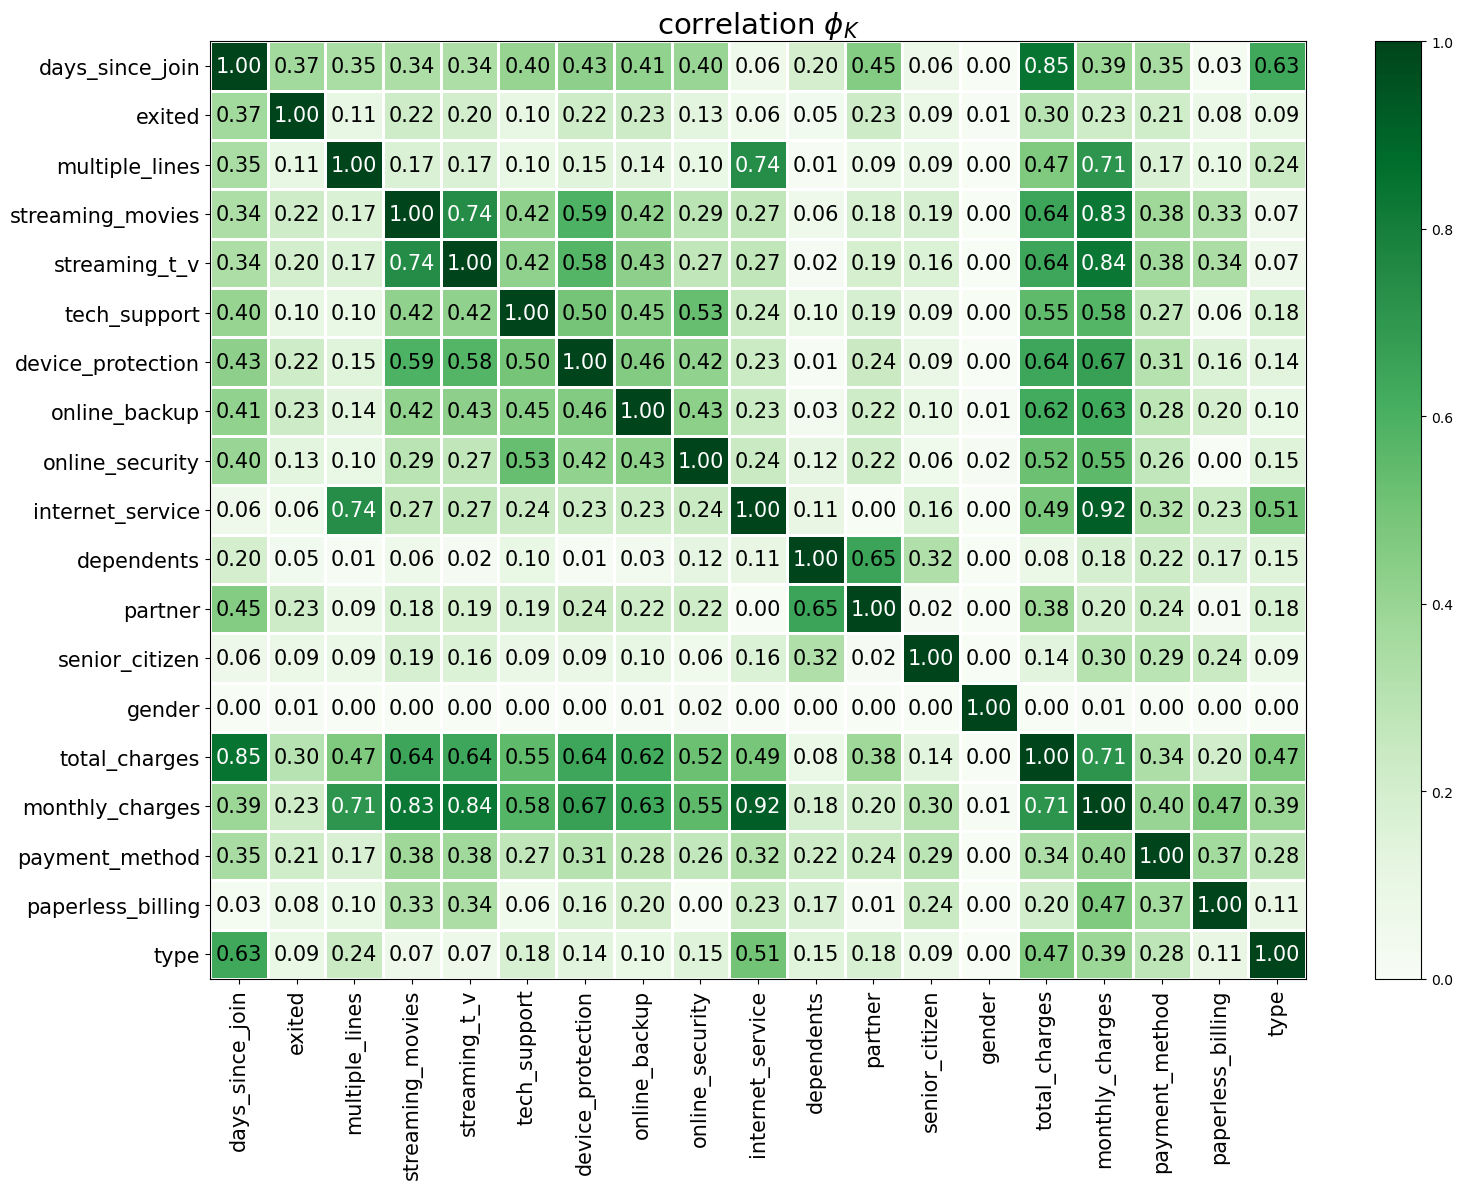

In [34]:
plot_correlation_matrix(phik_overview.values, x_labels=phik_overview.columns, y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map='Greens', title=r'correlation $\phi_K$', fontsize_factor=1.5,
                        figsize=(16, 12))
plt.tight_layout()

**Обнаружена**  
* высокая корелляция (от 0,7 до 0.9) между признаками monthly_charges и total_charges, streaming_movies, streaming_t_v.
* высокая корелляция между total_charges и days_since_join.
* очень высокая корелляция (свыше 0.9) между monthly_charges и internet_service.

**Выводы**
* На ежемесячный счет влияют подклченные услуги со стриминговыми сервисами, а особенно подключенный интернет. 
* Общая сумма затрат будет тем больше, чем дольше пользователь является клиентом заказчика.

**Изучим признаки в соотношении с группой ушедших и оставшихся клиентов**

Численные признаки

In [35]:
# формируем два датасета с активными клиентами и ушедшими
active_clients = df[df['exited'] == 0]
exited_clients = df[df['exited'] == 1]

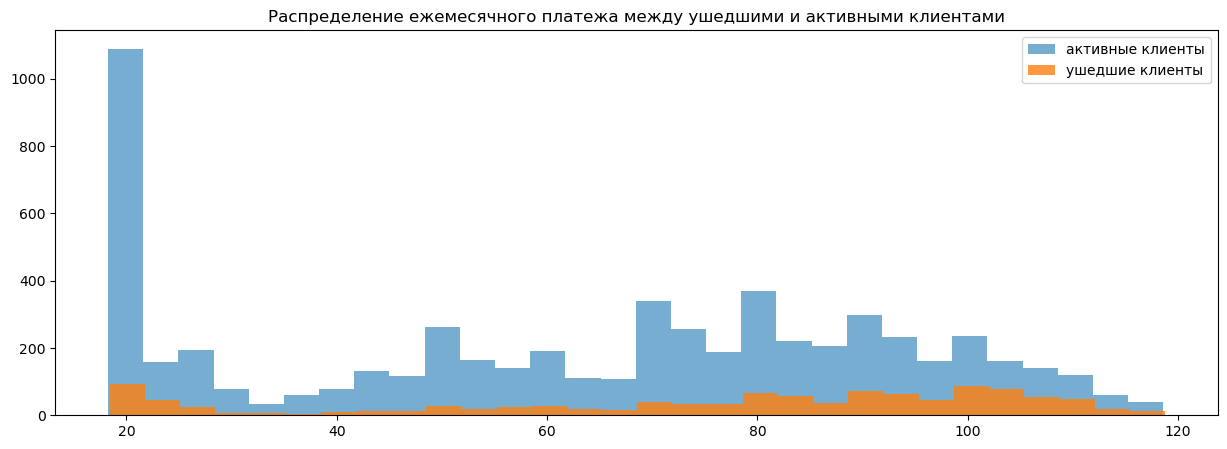

In [36]:
plt.figure(figsize=(15,5))
plt.hist(active_clients['monthly_charges'], bins=30, alpha=0.6, label='активные клиенты')
plt.hist(exited_clients['monthly_charges'], bins=30, alpha=0.8, label='ушедшие клиенты')
plt.legend()
plt.title('Распределение ежемесячного платежа между ушедшими и активными клиентами');

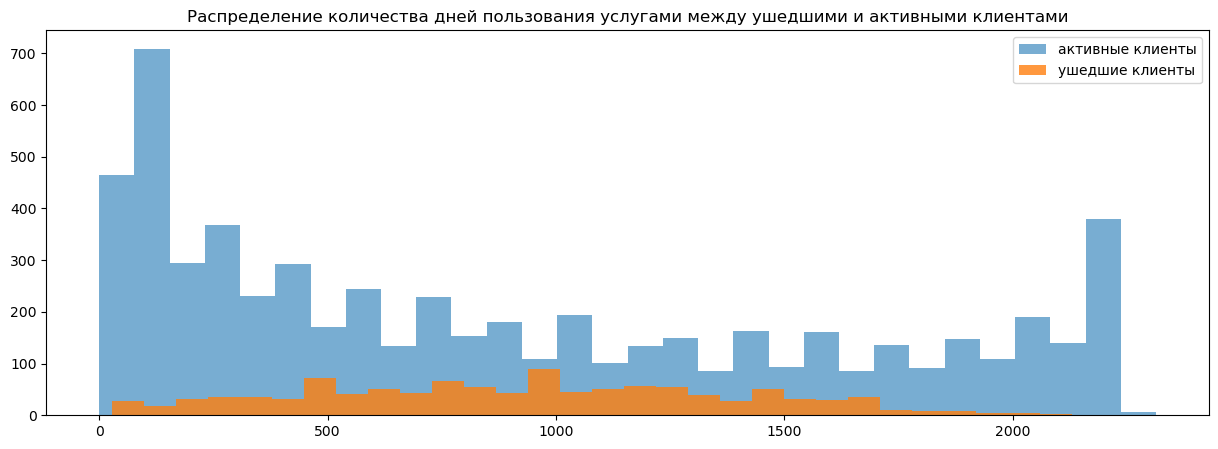

In [37]:
plt.figure(figsize=(15,5))
plt.hist(active_clients['days_since_join'], bins=30, alpha=0.6, label='активные клиенты')
plt.hist(exited_clients['days_since_join'], bins=30, alpha=0.8, label='ушедшие клиенты')
plt.legend()
plt.title('Распределение количества дней пользования услугами между ушедшими и активными клиентами');

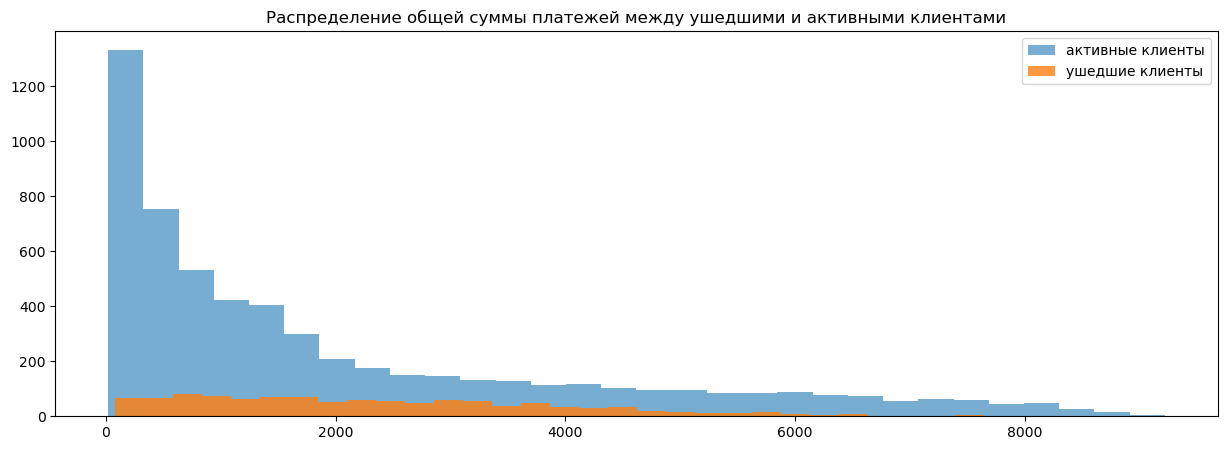

In [38]:
plt.figure(figsize=(15,5))
plt.hist(active_clients['total_charges'], bins=30, alpha=0.6, label='активные клиенты')
plt.hist(exited_clients['total_charges'], bins=30, alpha=0.8, label='ушедшие клиенты')
plt.legend()
plt.title('Распределение общей суммы платежей между ушедшими и активными клиентами');

**Выводы**  
* у ушедших клиентов в среднем счет выше, чем у оставшихся.
* ушедшие клиенты в среднем дольше пользуются услугами оператора.
* имеется группа клиентов, которые очень долго пользуется услугами оператора (более 5 лет): это очень лояльная категория (возможно связано с лояльностью к бренду или оплату услуг работодателем)

Ушедших клиентов не устраивают условия пользования услугами оператора: лояльность клиентов снижается с течением времени. Возможно для клиентов, пользущихся услугами более года проводить дополнительный акции по увеличению лояльности, а также предлагать клиентам оценивать качество предоставляемых услуг. 

In [39]:
categories = {
    'type': 'Тип договора',
    'paperless_billing':'Выставление счета на e-mail', 
    'payment_method': 'Способ оплаты', 
    'gender': 'Пол клиента',       
    'senior_citizen': 'Статус пенсионера', 
    'partner': 'Наличие партнера',
    'dependents': 'Наличие иждивенцев', 
    'internet_service': 'Подключен Интернет',      
    'online_security': 'Подключен межсетевой экран', 
    'online_backup': 'Подключено облачное хранилище', 
    'device_protection': 'Подключен антивирус', 
    'tech_support': 'Подключена услуга техподдержки',       
    'streaming_t_v': 'Подключено онлайн-ТВ', 
    'streaming_movies': 'Подключен онлайн-кинотеатр', 
    'multiple_lines': 'Возможность подключения телефонного аппарата к нескольким линиям одновременно' 
                    }

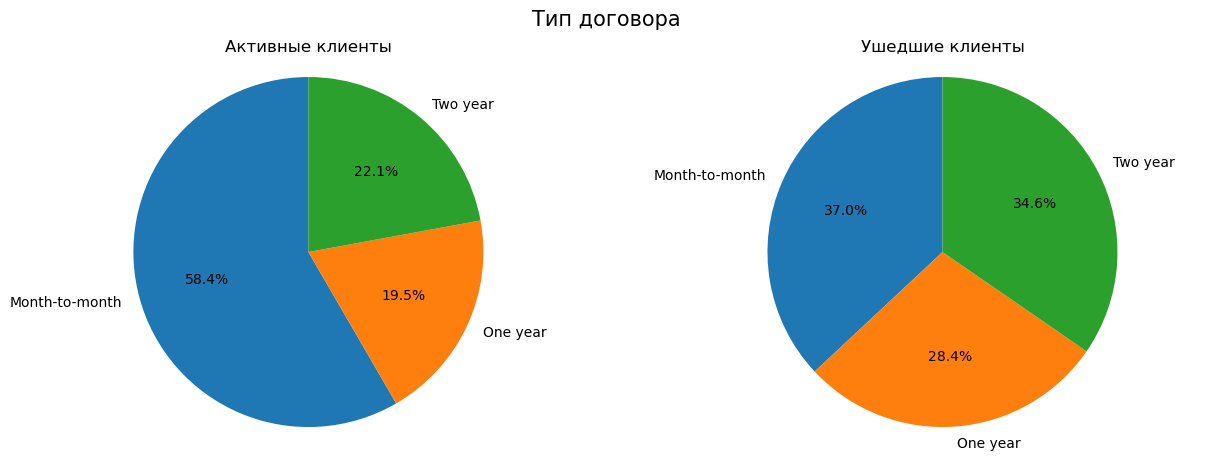

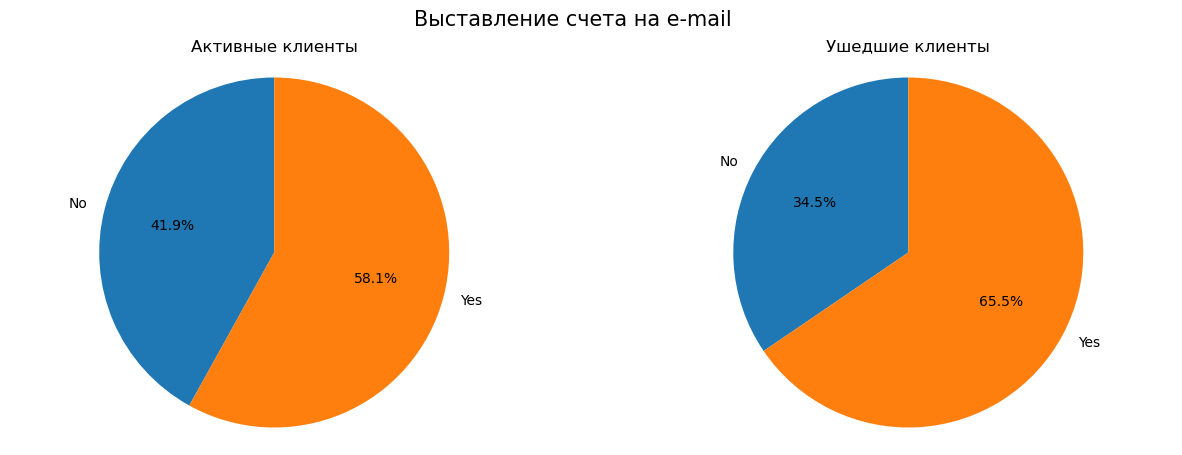

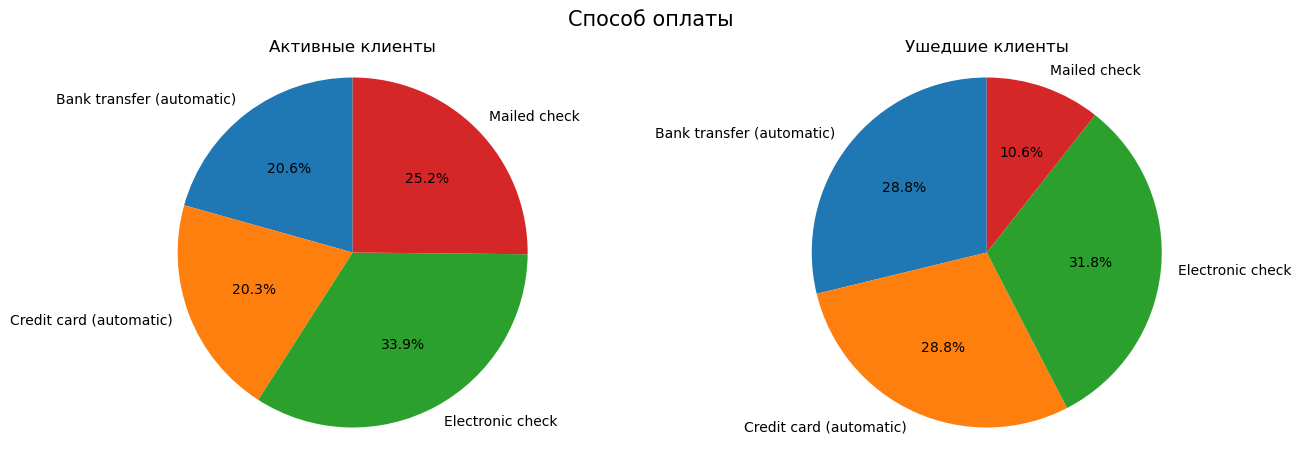

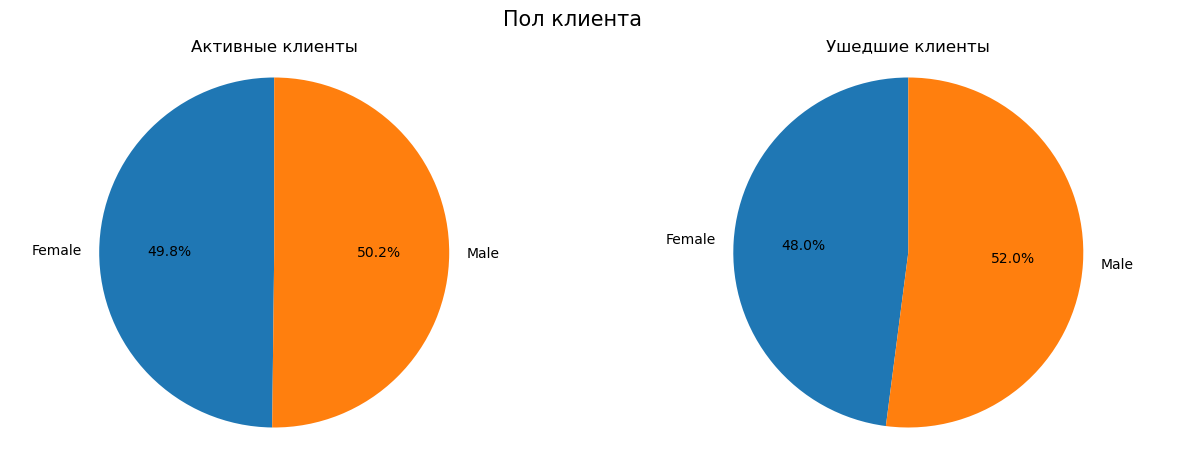

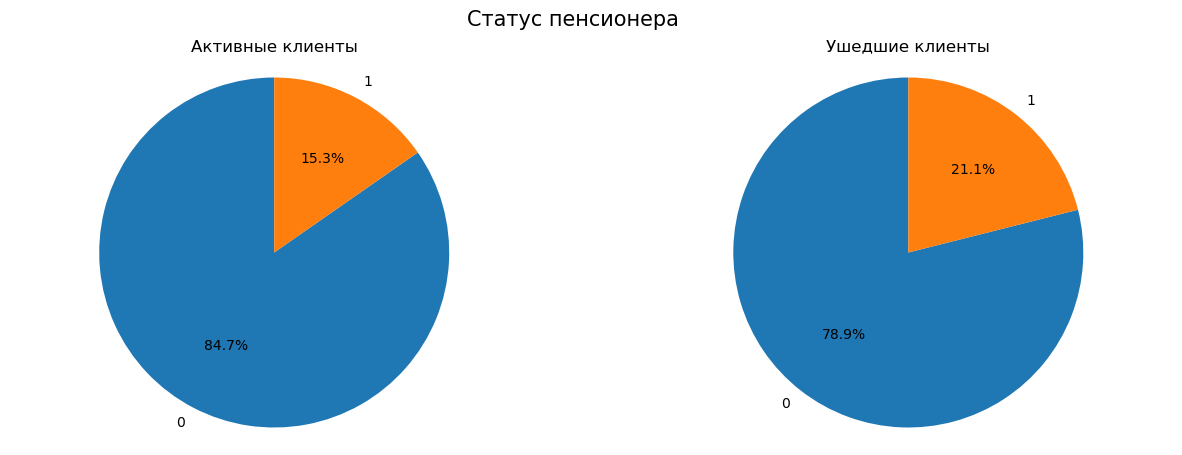

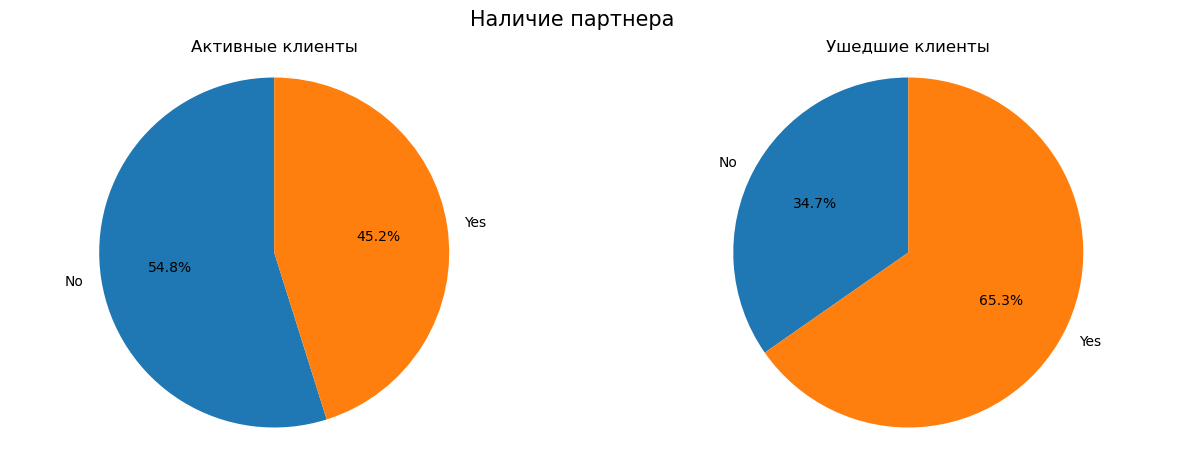

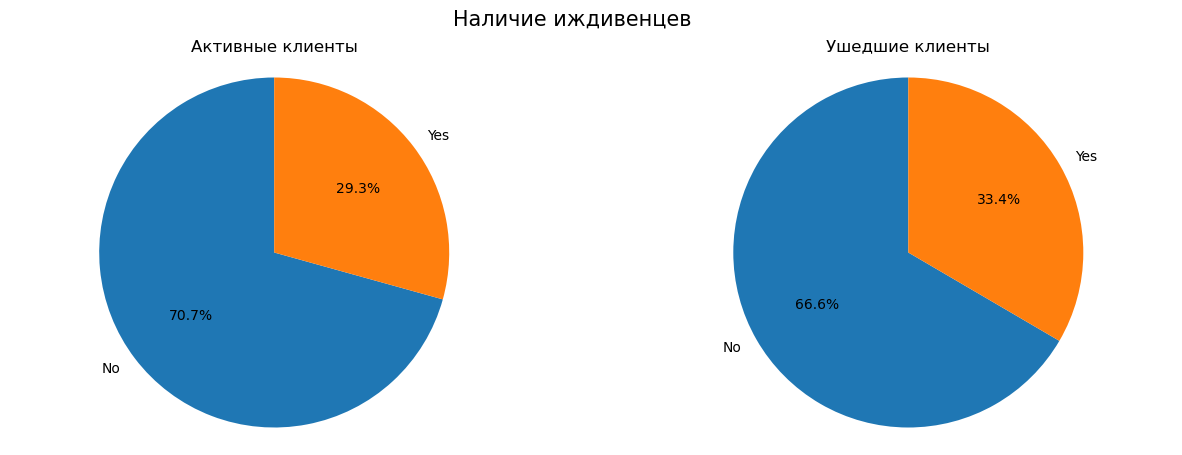

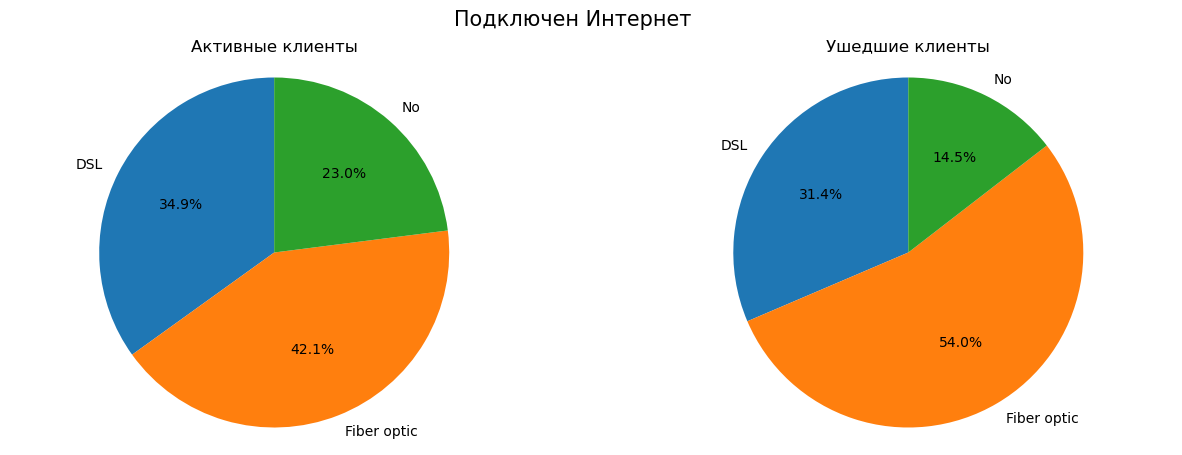

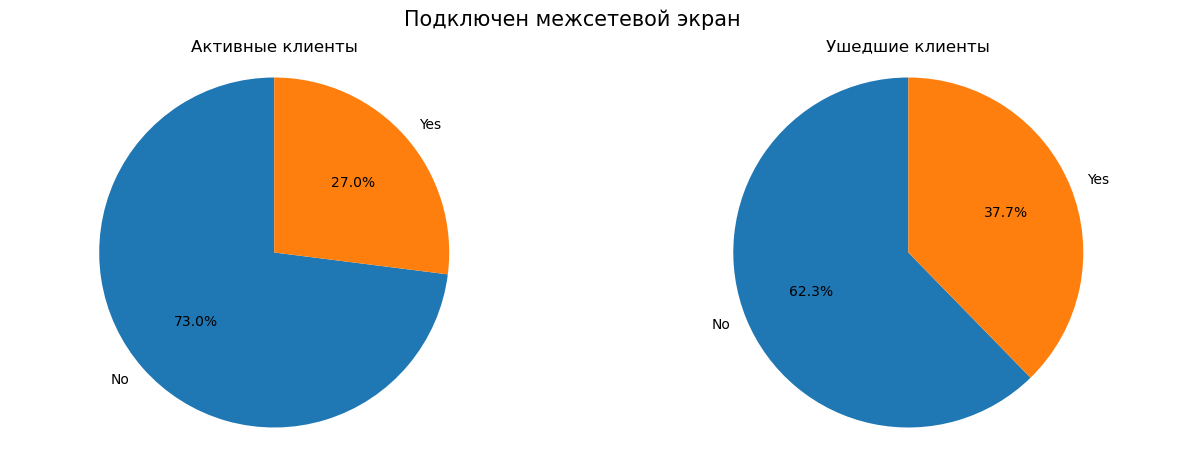

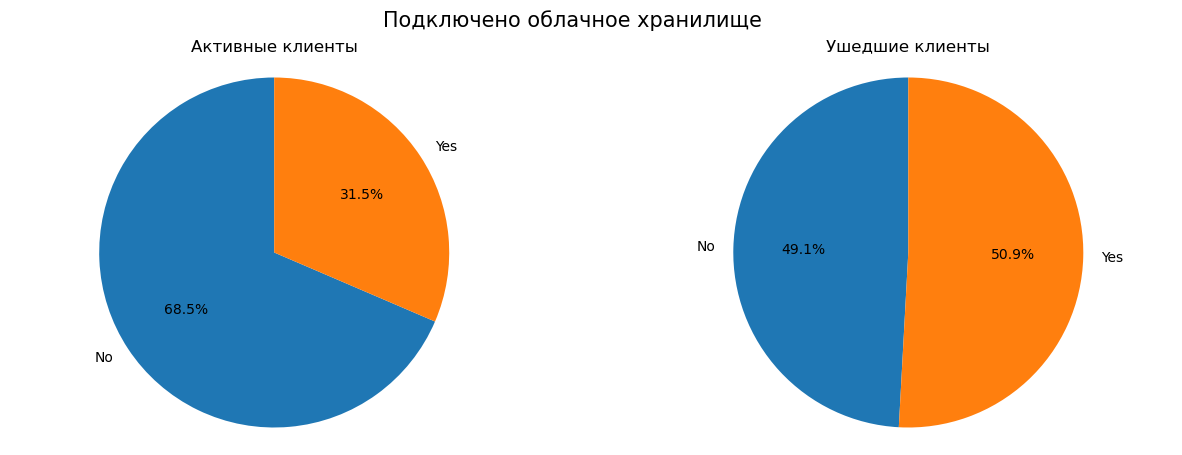

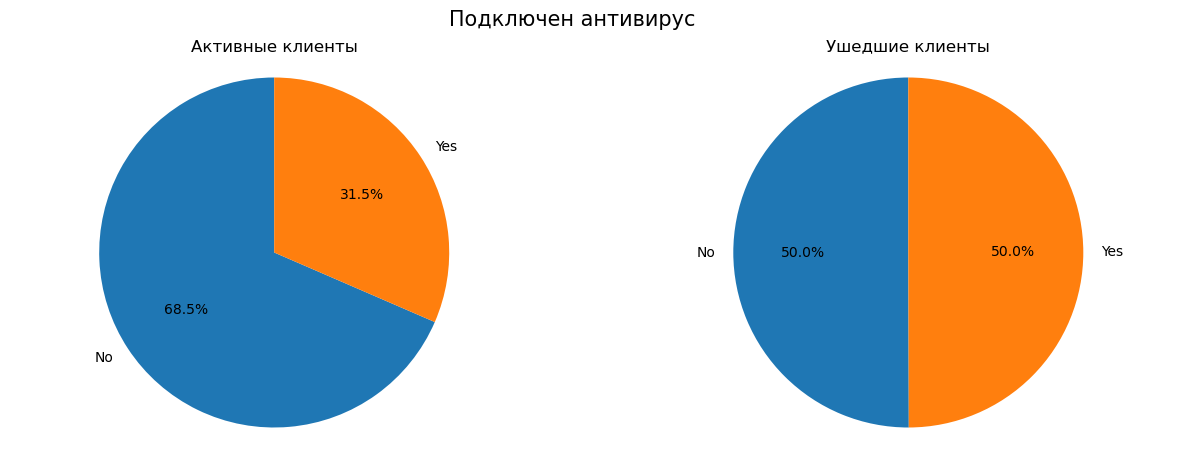

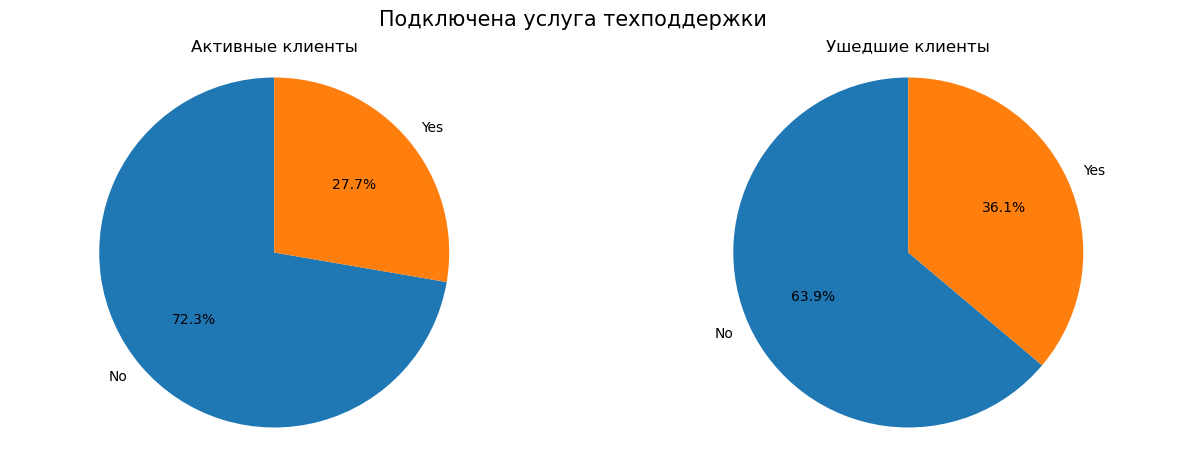

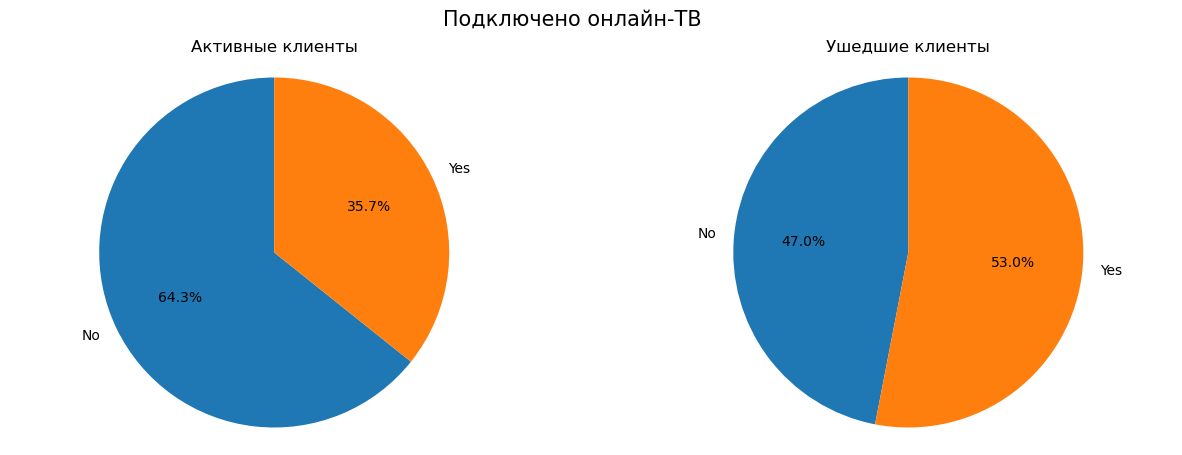

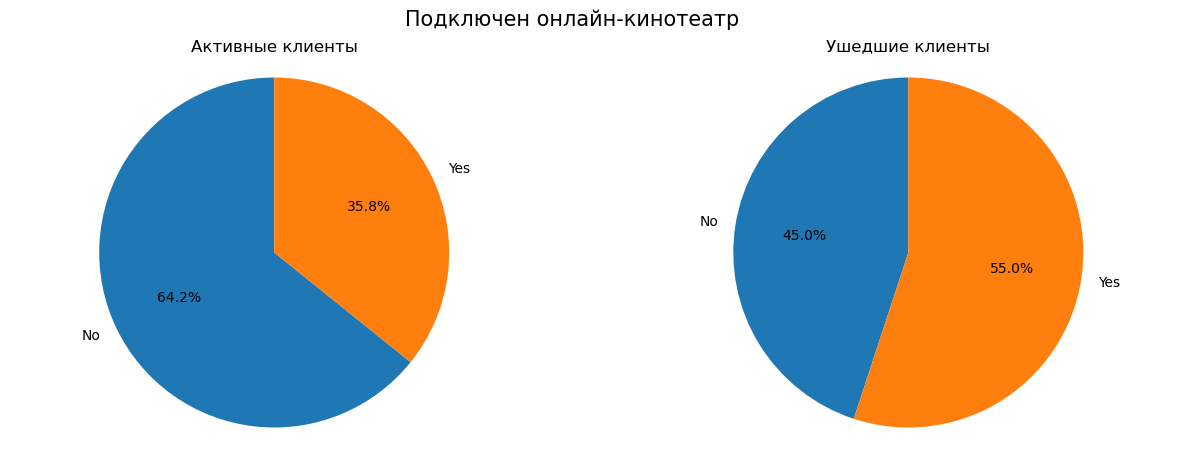

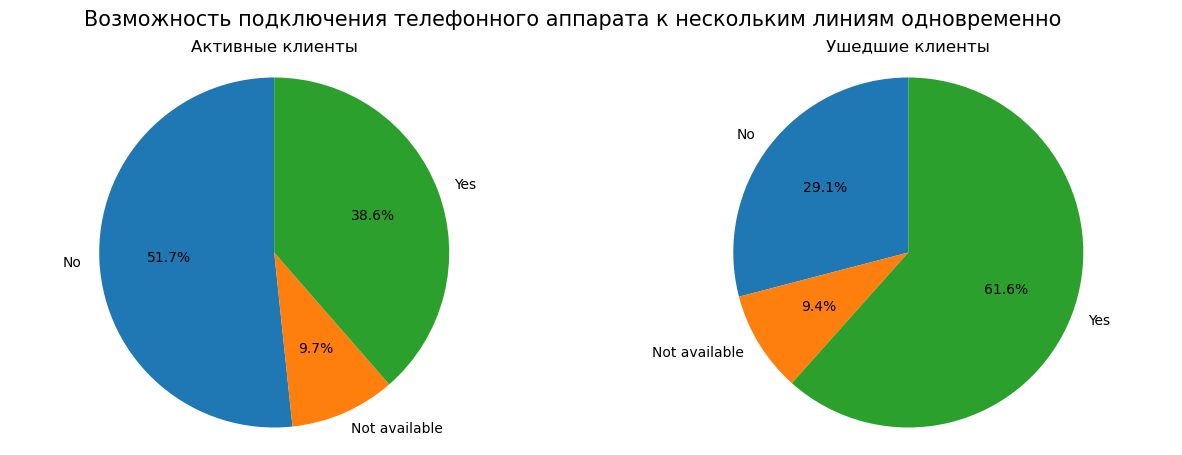

In [40]:
for col, name in categories.items():
    
    active_service = active_clients.groupby(col)[col].count()/active_clients.shape[0]
    exited_service = exited_clients.groupby(col)[col].count()/exited_clients.shape[0]

    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5)) 

    fig.suptitle(name, fontsize=15)

    labels = active_service.index
    sizes = active_service

    ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
    ax1.axis('equal')  
    ax1.set_title('Активные клиенты')

    labels = exited_service.index
    sizes = exited_service

    ax2.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
    ax2.axis('equal')  
    ax2.set_title('Ушедшие клиенты');

**Выводы**
* среди ушедших клиентов в сравнении с группой активных клиентов больше тех, у кого заключены длительные договоры (1 и 2 года). Скорее всего по итогу клиенту не нравится заплатив сразу большую сумму за 1 или 2 года, не иметь возможности дальнейшей корректировки тарифа.
* отправка счета на e-mail незначительно отличается в группах ушедших и активных клиентов.
* среди ушедших клиентов в сравнении с группой активных клиентов в 2 раза меньше тех, кто оплачивает счет, приходящий на почту, но на 8% больше тех, у кого списывается оплата услуг автоматически. Возможно клиентов не устраивает внезапное списание средств.
* пол клиентов не влияет на решение отказаться от услуг оператора.
* среди ушедших клиентов в сравнении с группой активных клиентов на 6% больше количество клиентов пенсионного возраста. К людям в таком статусе требуется более внимательный подход при планировании акций. 
* среди ушедших клиентов в сравнении с группой активных клиентов на 20% больше тех, кто имеет партнера. Следует рассмотреть возможность предоставления более выгодного тарифа для пар.
* наличие иждивенцев не отличает группы клиентов.
* среди ушедших клиентов в сравнении с группой активных клиентов больше тех, кто пользуется Интернетом, особенно оптоволокном. Возможно клиентов не устраивает качество связи или соотношение цена/качество.
* по всем остальным услугам явная разница между группами: ушедшие клиенты в большинстве своем пользовались дополнительными опциями (онлайн-ТВ, онлайн-кинотеатр, антивирус и т.д.). Это говорит о том, что пользователи не увидели ценности в данных услугах и решили вовсе отказаться.

### Формирование выборок для моделирования

In [41]:
categorical_features = list(categories.keys())

In [42]:
RANDOM_STATE = 310723

In [43]:
# формируем выборки с признаками для обучения и целевым в соотношении 3:1
features = df.drop('exited', axis=1)
target = df['exited']

X_train, X_test, y_train, y_test = train_test_split(features, target,
    test_size=0.25, shuffle=True, random_state=RANDOM_STATE, stratify=target)

In [44]:
# проверяем верно ли выполнена разбивка
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape, sep='\n')

(5282, 18)
(1761, 18)
(5282,)
(1761,)


### Обучение моделей и подбор гиперпараметров

Для выполнения поставленной задачи выбраны три модели:
* LogisticRegression
* RandomForestClassifier
* CatBoostClassifier

При обучении моделей потребуется выполнить преобразование данных: 
* кодирование категориальных признаков (прямое - для LogisticRegression, порядковое - для RandomForestClassifier)
* масштабирование численных признаков (для RandomForestClassifier данный этап не требуется)

Для того, чтобы выполнять одновременно операции по преобразованию данных воспользуемся конвейрами в паре ColumnTransformer + Pipeline, а далее передадим данные в GridSearchCV для автоматического подбора гиперпараметров.

При подборе гиперпараметров метриками качества укажем следующие:
* основная метрика качества - AUC-ROC (в результате должна быть больше 0,85)
* дополнительная метрика качества - accuracy

In [45]:
### Функция вывода параметров и метрик модели

def model_params(grid_model):
    best_params = pd.DataFrame(grid_model.best_params_, index=[0])

    model_roc_auc= grid_model.best_score_
    index_roc_auc = grid_model.best_index_
    model_accuracy = grid_model.cv_results_['mean_test_accuracy'][index_roc_auc]

    best_params['roc_auc'] = model_roc_auc
    best_params['accuracy'] = model_accuracy
    
    return best_params 


#### Логистическая регрессия

In [46]:
%%time
col_transformer_model_1 = make_column_transformer(
                             (OneHotEncoder(drop='first'), categorical_features), 
                             (StandardScaler(), numerical_features), remainder='passthrough')

model_1 = LogisticRegression(random_state=RANDOM_STATE)

pipeline = Pipeline([('prep', col_transformer_model_1),('model_1', model_1)])

params = {'model_1__penalty': ['l1', 'l2'], 
          'model_1__C': np.arange(0.01,1,0.01), 
          }

grid_model_1 = GridSearchCV(pipeline, cv=4, verbose=0, n_jobs=-1, 
                            param_grid=params, scoring=['accuracy','roc_auc'], refit='roc_auc')

grid_model_1.fit(X_train, y_train)

CPU times: total: 8.05 s
Wall time: 14.7 s


GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['type',
                                                                          'paperless_billing',
                                                                          'payment_method',
                                                                          'gender',
                                                                          'senior_citizen',
                                                                          'partner',
                                                                          'dependents',
                                                                          'internet_service',
                                                                          'online_security',
                                                                          'online_backup',
                                                                          'device_protection',
                                                                          'tech_support',
                                                                          'streaming_t_v'...
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
       0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
       0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]),
                         'model_1__penalty': ['l1', 'l2']},
             refit='roc_auc', scoring=['accuracy', 'roc_auc'])

In [47]:
model_params(grid_model_1)

,model_1__C,model_1__penalty,roc_auc,accuracy
0,0.47,l2,0.777734,0.86312


#### Случайный лес деревьев

In [48]:
%%time
col_transformer_model_2 = make_column_transformer(
                             (OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categorical_features), 
                             remainder='passthrough')

model_2 = RandomForestClassifier(random_state=RANDOM_STATE)

pipeline = Pipeline(steps=[('prep', col_transformer_model_2),('model_2', model_2)])

params = {'model_2__n_estimators': range(1, 201, 10), 
          'model_2__max_depth': range(4, 12), 
          }

grid_model_2 = GridSearchCV(pipeline, cv=4, verbose=0, n_jobs=-1, 
                            param_grid=params, scoring=['accuracy','roc_auc'], refit='roc_auc')

grid_model_2.fit(X_train, y_train)

CPU times: total: 7.16 s
Wall time: 1min 21s


GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ordinalencoder',
                                                                         OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                        unknown_value=-1),
                                                                         ['type',
                                                                          'paperless_billing',
                                                                          'payment_method',
                                                                          'gender',
                                                                          'senior_citizen',
                                                                          'partner',
                                                                          'dependents',
                                                                          'internet_service',
                                                                          'online_security',
                                                                          'online_backup',
                                                                          'device_protection',
                                                                          'tech_support',
                                                                          'streaming_t_v',
                                                                          'streaming_movies',
                                                                          'multiple_lines'])])),
                                       ('model_2',
                                        RandomForestClassifier(random_state=310723))]),
             n_jobs=-1,
             param_grid={'model_2__max_depth': range(4, 12),
                         'model_2__n_estimators': range(1, 201, 10)},
             refit='roc_auc', scoring=['accuracy', 'roc_auc'])

In [49]:
model_params(grid_model_2)

,model_2__max_depth,model_2__n_estimators,roc_auc,accuracy
0,7,101,0.838265,0.858386


#### Градиентный бустинг

In [50]:
%%time

model_3 = CatBoostClassifier(random_state=RANDOM_STATE,verbose=0, 
                             cat_features=categorical_features)

params = {'learning_rate': [0.1, 0.2, 0.3], 
          'depth': range(2, 10), 
          'iterations': [200, 300, 400, 500, 1000]}

grid_model_3 = GridSearchCV(model_3, cv=4, verbose=0, n_jobs=-1, 
                            param_grid=params, scoring=['accuracy','roc_auc'], refit='roc_auc')

grid_model_3.fit(X_train, y_train)

CPU times: total: 46.3 s
Wall time: 34min 28s


GridSearchCV(cv=4,
             estimator=<catboost.core.CatBoostClassifier object at 0x000001FEB414FD00>,
             n_jobs=-1,
             param_grid={'depth': range(2, 10),
                         'iterations': [200, 300, 400, 500, 1000],
                         'learning_rate': [0.1, 0.2, 0.3]},
             refit='roc_auc', scoring=['accuracy', 'roc_auc'])

In [51]:
model_params(grid_model_3)

,depth,iterations,learning_rate,roc_auc,accuracy
0,2,1000,0.3,0.922439,0.929571


### Выбор лучшей модели и проверка ее метрики на тестовой выборке

Для наглядности выбора лучшей модели построим диаграмму с оценкой основной метрики качества - ROC_AUC

In [52]:
models = pd.DataFrame({
    'Model': ['LogisticRegression', 'RandomForestClassifier', 'CatBoostClassifier'],
    'ROC_AUC': [grid_model_1.best_score_, grid_model_2.best_score_, grid_model_3.best_score_]})
sorted_by_score = models.sort_values(by='ROC_AUC', ascending=False)

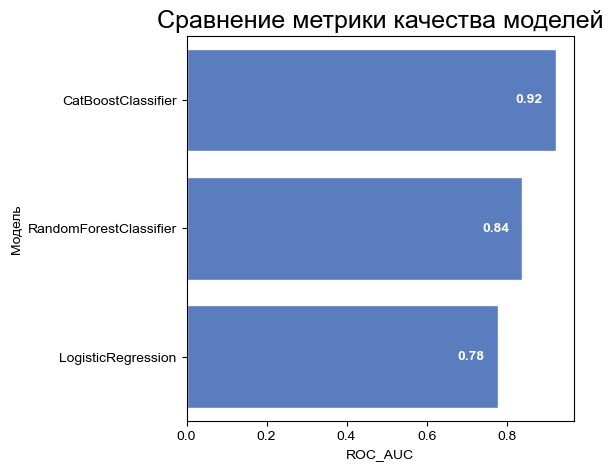

In [53]:
ig, axs = plt.subplots(1,1,figsize=(5,5))
sns.set(font_scale=1.5)
sns.set_color_codes("muted")
sns.barplot(x='ROC_AUC', y = 'Model', data = sorted_by_score, color = 'b')
values = models.sort_values(by='ROC_AUC', ascending=False)['ROC_AUC']
plt.title('Сравнение метрики качества моделей')
plt.xlabel('ROC_AUC')
plt.ylabel('Модель')
for counter, value in enumerate(values):
    axs.text(value - 0.1, counter, round(value,2), color='white', va='center', fontsize=10, fontweight='bold')

В итоге лучшей моделью является **CatBoostClassifier**

Проверим метрики качества на тестовой выборке

In [54]:
best_model = grid_model_3
round(roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1]), 2)

92.84

Значения метрики на тестовой и обучающей выборке почти не отличаются, значит модель обучилась достаточно хорошо, параметры подобраны корректно.

In [55]:
round(accuracy_score(y_test, best_model.predict(X_test)), 2)

93.3

### Анализ важности признаков и метрик качества

#### ROC-curve

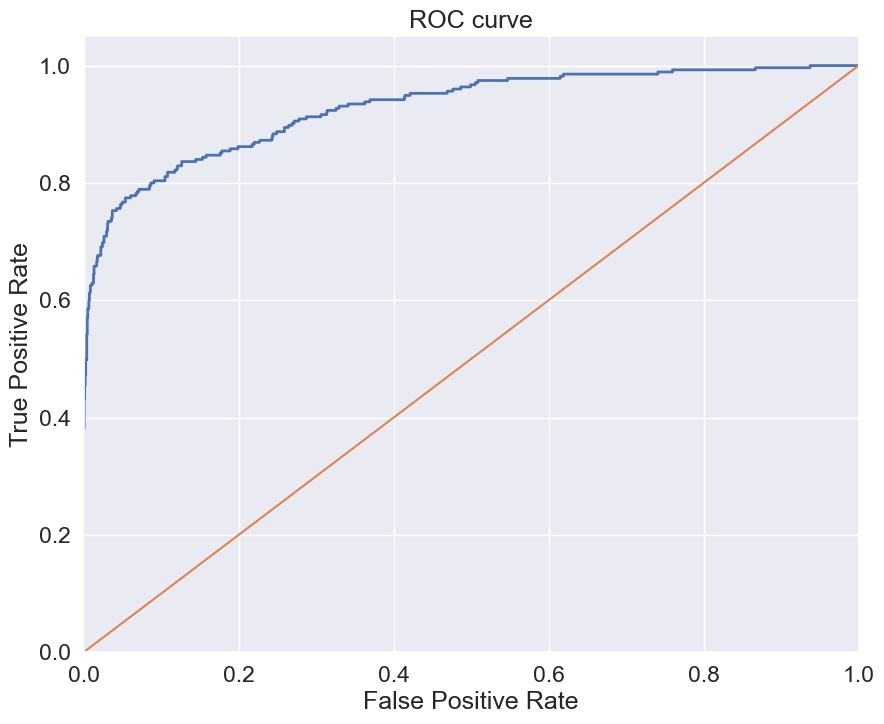

In [56]:
# построение ROC-кривой

sns.set(font_scale=1.5)
sns.set_color_codes("muted")

plt.figure(figsize=(10, 8))
fpr, tpr, thresholds = roc_curve(y_test, best_model.predict_proba(X_test)[:, 1], pos_label=1)
lw = 2
plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.savefig("ROC.png")
plt.show()

**Вывод**: Т.к. кривая расположена близко к верхнему левому углу, то предсказательная способность модели достаточно хорошая.

#### Сonfusion matrix

Confusion matrix, without normalization
[[1466   20]
 [  98  177]]


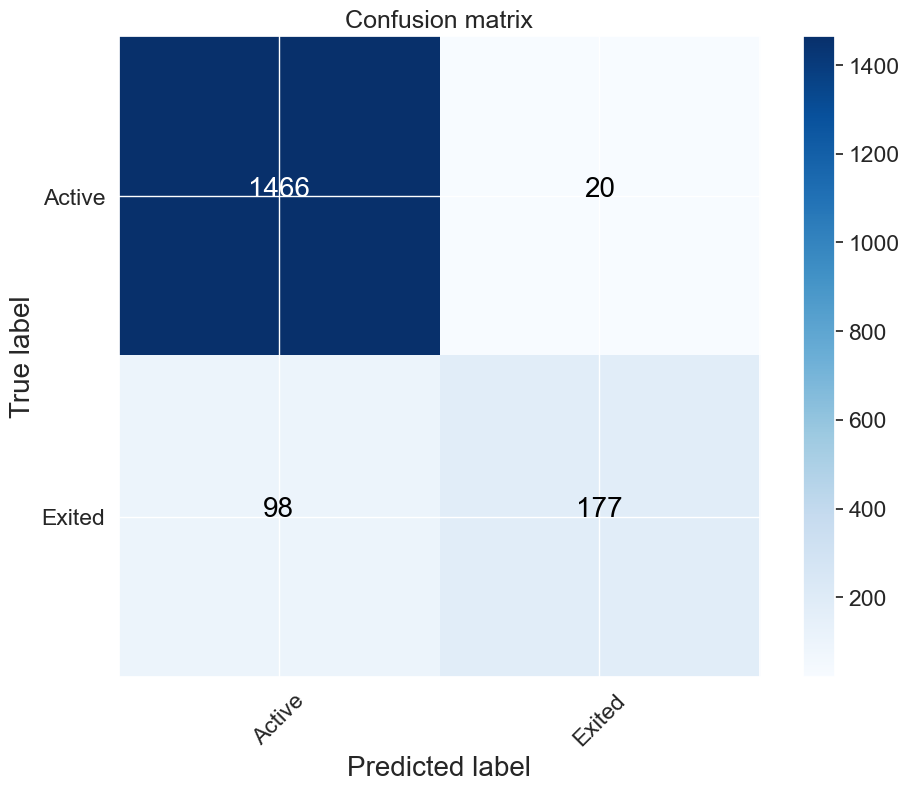

In [57]:
# Воспользуемся функцией построения матрицы ошибок из документации sklearn

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

font = {'size' : 20}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, best_model.predict(X_test))
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Active', 'Exited'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

**Вывод**: значений false negative достаточно много: модель недостаточно хорошо определяет уйдет ли клиент, а вот то, что он останется определяет почти идеально.

#### Feature importances

Для анализа важности признаков воспользуемся библиотекой shap

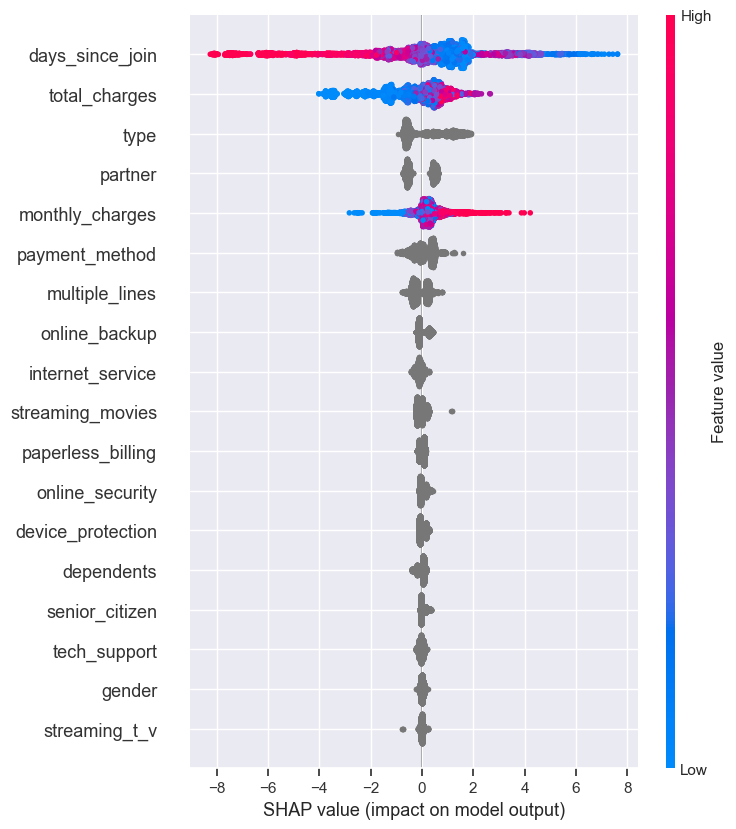

In [58]:
shap_values = shap.TreeExplainer(best_model.best_estimator_).shap_values(X_train)

shap.summary_plot(shap_values, X_train, max_display=25, auto_size_plot=True)

**Выводы**

Наиболее значимые признаки: 
* Количество дней пользования услугами оператора (days_since_join): больше влияет на отнесение к классу 0 (клиент остался).
* Тип договора (различается по длительности)
* Общая сумма завтрат: больше влияет на отнесение к классу 1 (клиент ушел)
* Наличие партнера
* Ежемесячная плата: значительно влияет на отнесение к классу 1 (клиент ушел)

### Отчет по результатам исследования

Целью проекта была разработка модели бинарной классификации для оператора связи «Ниединогоразрыва.ком», которая бы прогнозировала отток клиентов на основе персональных данных клиентов, включая информацию информацию об их тарифах и договорах. Основное пожелание заказчика - снизить убытки, связанные с неэффективными акциями по удержанию клиентов.

По условиям задания основная метрика качества, AUC-ROC, должна быть больше 0.85.

#### Ключевые шаги в решении задачи

Перед началом решения задачи был составлен план работ. Были выполнены следущие этапы:

**1. Импорт библиотек и загрузка данных**

* Были установлены и загружены все необходимые библиотеки. 
* Изначально от Заказчика поступили 4 файла с данными о клиентах. Все данные были загружены, интерпретированы признаки в каждом из файлов.

**2. Объединение данных и выделение целевого признака**

* Для объединения таблиц в общую была выполнена "склейка" по полю идентификатор пользователя. 
* Для формирования целевого признака - ушел/остался клиент - был создан дополнительный признак по дате окончания договора. При оценке распределения целевого признака, количества ушедших и оставшихся клиентов, был выявлен дисбаланс классов. Для того, чтобы модель учитывала эту особенность, будет необходимо выполнить разбивку на выборки с использованием параметра "stratify", который сделает выборки с равномерным распределением классов

**3. Предобработка данных**

При изучении данных были поставлены следующие задачи:
* Обработать пропуски в столбцах InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, StreamingTV, StreamingMovies, StreamingMovies, MultipleLines. Наиболее вероятная причина пропусков в том, что пользователь не подключал услуги.
* Необходимо изменить типы данных для следущих признаков: total_charges - привести к типу float, begin_date, end_date - к datetime, senior_citizen - к object. Большинство признаков катеогриальные. К числовым относятся только MonthlyCharges и TotalCharges.
* Для понимания длительности пользования услугами каждого клиента потребуется создать дополнительный столбец days_since_join. 
* Признаки с датами необходимо будет удалить после формирования нового признака, а также удалить столбец с индентификатором пользователя.
* Скорректировать пустые значения в столбце TotalCharges. При рассмотрении строк с пустыми значениями, выявлено, что такие данные у новых пользователей, которые появлись на момент формирования данных - 01.02.2020.

Итоги предобработки: 
* Заменены  пропуски в столбцах InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, StreamingTV, StreamingMovies, StreamingMovies на значение 'No', т.к. пользователи не используют данные услуги.
* Заменены  пропуски в столбце MultipleLines на 'Not available', т.к. пользователи намеренно отказались от данной услуги.
* Заменены пустые значения в столбце TotalCharges на значения из столбца monthly_charges,т.к. ежемесячная оплата - та общая сумма, котору платит новый клиент за подключение.
* Выполнена корректировка типов данных.
* Добавлен столбец с количеством дней пользования услугами оператора
* Удалены лишние столбцы.

**4. Исследовательский анализ данных**

Для анализа взаимосвязей между признаками была использована библиотека phik. В результате были обнаружены следущие корелляции: 
* высокая корелляция (от 0,7 до 0.9) между признаками monthly_charges и total_charges, streaming_movies, streaming_t_v.
* высокая корелляция между total_charges и days_since_join.
* очень высокая корелляция (свыше 0.9) между monthly_charges и internet_service.

Из чего делаем следущий вывод:
* На ежемесячный счет наиболее сильно влияет подключенный интернет, а также услуги со стриминговыми сервисами. 
* Общая сумма затрат будет тем больше, чем дольше пользователь является клиентом заказчика.

Также были проанализированы численные признаки для каждого класса (ушедшие и оставшиеся клиенты):

* у ушедших клиентов в среднем счет выше, чем у оставшихся.
* ушедшие клиенты в среднем дольше пользуются услугами оператора.
* имеется группа клиентов, которые очень долго пользуется услугами оператора (более 5 лет): это очень лояльная категория (возможно связано с лояльностью к бренду или оплату услуг работодателем)

При анализе категориальных переменных в разрезе классов обнаружено следующее:
* среди ушедших клиентов в сравнении с группой активных клиентов больше тех, у кого заключены длительные договоры (1 и 2 года). Скорее всего по итогу клиенту не нравится заплатив сразу большую сумму за 1 или 2 года, не иметь возможности дальнейшей корректировки тарифа.
* отправка счета на e-mail незначительно отличается в группах ушедших и активных клиентов.
* среди ушедших клиентов в сравнении с группой активных клиентов в 2 раза меньше тех, кто оплачивает счет, приходящий на почту, но на 8% больше тех, у кого списывается оплата услуг автоматически. Возможно клиентов не устраивает внезапное списание средств.
* пол клиентов не влияет на решение отказаться от услуг оператора.
* среди ушедших клиентов в сравнении с группой активных клиентов на 6% больше количество клиентов пенсионного возраста. К людям в таком статусе требуется более внимательный подход при планировании акций. 
* среди ушедших клиентов в сравнении с группой активных клиентов на 20% больше тех, кто имеет партнера. Следует рассмотреть возможность предоставления более выгодного тарифа для пар.
* наличие иждивенцев не отличает группы клиентов.
* среди ушедших клиентов в сравнении с группой активных клиентов больше тех, кто пользуется Интернетом, особенно оптоволокном. Возможно клиентов не устраивает качество связи или соотношение цена/качество.
* по всем остальным интернет-услугам явная разница между группами: ушедшие клиенты в большинстве своем пользовались дополнительными опциями (онлайн-ТВ, онлайн-кинотеатр, антивирус и т.д.). Это говорит о том, что пользователи не увидели ценности в данных услугах и решили вовсе отказаться.
* среди ушедших клиентов на 40% больше тех, кто пользовался возможностью подключения телефонного аппарата к нескольким линиям одновременно.

В итоге было решено оставить все имещиеся на этапе исследования признаки для моделирования, а после него провести анализ важности признаков.

**5. Формирование выборок для моделирования**

* Были сформированы обучающая и тестовая выборки в соотношении 3 к 1, с параметром stratify для учета дисбаланса классов.
* Кодирование категориальных признаков (прямое - для LogisticRegression, порядковое - для RandomForestClassifier) и масштабирование численных признаков (для LogisticRegression) в целях оптимизации было решено выполнить на этапе обучения модели.

**6. Обучение моделей и подбор гиперпараметров**
Для выполнения поставленной задачи выбраны три модели:
* LogisticRegression
* RandomForestClassifier
* CatBoostClassifier

При обучении моделей потребуется выполнить преобразование данных: 
* кодирование категориальных признаков (прямое - для LogisticRegression, порядковое - для RandomForestClassifier)
* масштабирование численных признаков (для RandomForestClassifier данный этап не требуется)

Для того, чтобы выполнять одновременно операции по преобразованию категориальных и числовых признаков были использованы конвейеры в паре ColumnTransformer + Pipeline, а далее выполнена передача данных в GridSearchCV для автоматического подбора гиперпараметров.

При подборе гиперпараметров метрики качества были следующие:
* основная метрика качества - AUC-ROC (в результате должна быть больше 0,85)
* дополнительная метрика качества - accuracy

Для вывода параметров и метрик качества лучших моделей на этапе обучения была написана функция.

**7. Выбор лучшей модели и проверка ее метрики на тестовой выборке**

По итогам обучения диаграмма сравнения метрик качества выглядит следующим образом.
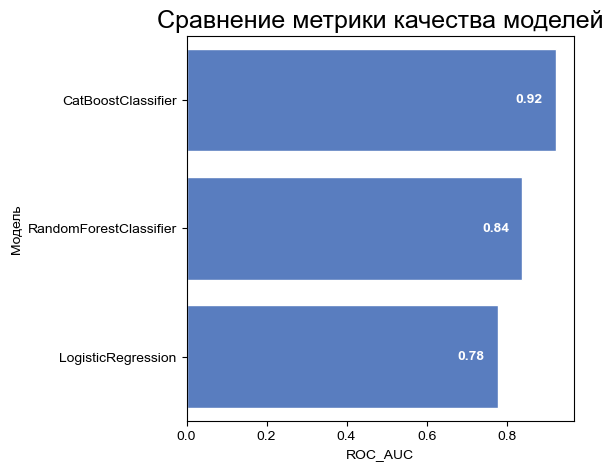

Лидером является **CatBoostClassifier** с результатом на обучающей выборке AUC ROC = 0.92, accuracy = 0.93.
При проверке метрик на тестовой выборке модель показала результат:
**AUC ROC** - 0.93
**accuracy** - 0.93

**8. Анализ важности признаков и метрик качества**

* ROC-кривая расположена близко к верхнему левому углу, т.е. предсказательная способность модели достаточно хорошая и параметры подобраны корректно.
* При построении матрицы ошибок выявлено большое количество ложно-отрицательных значений (35%): модель недостаточно хорошо определяет уйдет ли клиент, а вот то, что он останется определяет почти идеально (97%). Такие ошибки являются ошибками первого рода.

Наиболее значимые признаки:

* Количество дней пользования услугами оператора (days_since_join): больше влияет на отнесение к классу 0 (клиент остался).
* Тип договора (различается по длительности)
* Общая сумма завтрат: больше влияет на отнесение к классу 1 (клиент ушел)
* Наличие партнера
* Ежемесячная плата: значительно влияет на отнесение к классу 1 (клиент ушел)

#### Рекомендации о введении модели в эксплуатацию

* В связи с тем, что данная модель недостаточно точно определяет уход клиента, то на этапе опытной эксплутации стоит совместно с маркетологами подобрать порог классификации, чтобы оптимизировать метрики бизнеса в денежном выражении, учитывая стоимость ошибок первого рода, а также бюджет на акции по удержанию клиентов.
* Для улучшения качества модели также стоит рассмотреть возможность добавления признаков: например, является ли партнер клиента пользователем услуг оператора или нет (т.к. наличие партнера достаточно сильный признак), имеется ли у клиента корпоративная связь, наличие заработка и т.п.
* В качестве онлайн метрик стоит рассмотреть полноту и точность, которые лучше определяют долю правильно найденных и правильно предсказанных, соответственно, объектов из всех объектов предсказанных положительным классов (как раз то, что клиент уйдет).
* В дальнейшем можно использовать набор техник, которые позволяют предсказывать изменение в поведении индивидуума в результате какого-либо целевого воздействия (uplift моделирование), и a/b тесты.

#### Заключение

На этапе исследовательского анализа данных были выявлены некоторые возможные недостатки в услугах оператора, которые стоит обсудить с маркетологами и техническими специалистами, а именно:
* Ушедших клиентов не устраивают условия пользования услугами оператора: лояльность клиентов снижается с течением времени. Возможно для клиентов, пользущихся услугами более года следует проводить дополнительные акции по увеличению лояльности, а также предлагать клиентам оценивать качество предоставляемых услуг. 
* Пересмотреть условия семейного тарифа или предлагать выгодные условия для пар.
* Возможно стоит рассмотреть отказ от длительных договоров или изменить изх условия. 
* Для клиента списание средств стоит сделать предсказуемым: например, за несколько дней присылать уведомления.
* К клиентам в пенсионном возрасте требуется более внимательный подход: например, рассмотреть возможность пользования бесплатной техподдрежкой или . 
* Необходимо проверить технические харакетристики услуг, объем предоставляемых возможностей.Возможно клиентов не устраивает качество связи или соотношение цена/качество, или предлагаемый ассортимент доступных ресурсов в части интернет-услуг.